#### Goal
Goal of this notebook is to provide some visualizations for data inspection and feature engineering.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import json

sns.set_style('darkgrid')

In [3]:
# Load in data
prop_df = pd.read_hdf('../data/processed/bexar_processed.h5')

##### Plot Properties on Map

In [8]:
import folium
from folium.plugins import HeatMap
from folium import plugins

from geopy import geocoders
from geopy.extra.rate_limiter import RateLimiter

In [16]:
prop_df.crim_address.unique()

array([nan, '25319 BOERNE STAGE RD SAN ANTONIO, TX 78255',
       '24424 BLANCO RD SAN ANTONIO, TX 78260',
       '2227 SAWGRASS RDG SAN ANTONIO, TX 78260',
       '2243 WINDING VW SAN ANTONIO, TX 78260',
       '1115 LINKS CV SAN ANTONIO, TX 78260',
       '1220 LINKS LN SAN ANTONIO, TX 78260',
       '1228 LINKS LN SAN ANTONIO, TX 78260',
       '1247 LINKS LN SAN ANTONIO, TX 78260',
       '1103 OLYMPIC CLB SAN ANTONIO, TX 78260',
       '1220 PINYON HL SAN ANTONIO, TX 78260',
       '5 BOWOOD SAN ANTONIO , TX 78218',
       '1422 TWILIGHT RDG SAN ANTONIO, TX 78258',
       '1214 SUNSET VW SAN ANTONIO, TX 78258',
       '107 CHAMPIONS ML SAN ANTONIO, TX 78258',
       '6643 BISCAY BAY SAN ANTONIO, TX 78249',
       '6613 BISCAY BAY SAN ANTONIO, TX 78249',
       '25319 BUNKER DR SAN ANTONIO, TX 78260',
       '25118 CALLAWAY SAN ANTONIO, TX 78260',
       'HUNTRESS LN SAN ANTONIO, TX 78255',
       '19422 US HIGHWAY 281 N SAN ANTONIO, TX 78258',
       'N US HWY 281 SAN ANTONIO, TX 

In [31]:
mapping_crim_df = pd.DataFrame(data=prop_df.crim_address.unique())
mapping_crim_df.dropna(inplace=True)

In [35]:
mapping_crim_df.head()

,0
1,"25319 BOERNE STAGE RD SAN ANTONIO, TX 78255"
2,"24424 BLANCO RD SAN ANTONIO, TX 78260"
3,"2227 SAWGRASS RDG SAN ANTONIO, TX 78260"
4,"2243 WINDING VW SAN ANTONIO, TX 78260"
5,"1115 LINKS CV SAN ANTONIO, TX 78260"


In [47]:
locator = geocoders.Nominatim(user_agent="myGeocoder", country_bias='US')
geocode = RateLimiter(locator.geocode, min_delay_seconds=2)
address_dict={}
for i in mapping_crim_df[0].values:
    try:
        location = geocode(i, exactly_one=True)
        address_dict[i] = (location.latitude,location.longitude)
    
    except Exception:
        print('No geocode found at ', i)

/Users/matthewpokorny/anaconda3/envs/property_project_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `country_bias` argument of the Nominatim.__init__ is deprecated and will be removed in geopy 2.0. Use Nominatim.geocode(country_codes='US') instead.
  """Entry point for launching an IPython kernel.


No geocode found at  2227 SAWGRASS RDG SAN ANTONIO, TX 78260
No geocode found at  1103 OLYMPIC CLB SAN ANTONIO, TX 78260
No geocode found at  1220 PINYON HL SAN ANTONIO, TX 78260
No geocode found at  5 BOWOOD SAN ANTONIO , TX 78218
No geocode found at  1422 TWILIGHT RDG SAN ANTONIO, TX 78258
No geocode found at  107 CHAMPIONS ML SAN ANTONIO, TX 78258
No geocode found at  25205 TOUTANT BEAUREGARD RD  BOERNE, TX 78006
No geocode found at  25211 SPIDER ROCK  BOERNE, TX 78006
No geocode found at  10618 STAR MICA  BOERNE, TX 78006
No geocode found at  10607 STAR MICA  BOERNE, TX 78006
No geocode found at  10611 STAR MICA  BOERNE, TX 78006
No geocode found at  10615 STAR MICA  BOERNE, TX 78006
No geocode found at  10619 STAR MICA  BOERNE, TX 78006
No geocode found at  10623 STAR MICA  BOERNE, TX 78006
No geocode found at  TOUTANT BEAUREGARD RD  BOERNE, TX 78006
No geocode found at  1227 W OAK ESTATES DR SAN ANTONIO, TX 78260


In [48]:
mapping_crim_df['geolocation'] = mapping_crim_df[0].map(address_dict)

In [55]:
# mapping_crim_df.drop(columns=['latitude','longitude'],inplace=True)
mapping_crim_df.head()
mapping_crim_df[['latitude', 'longitude']] = pd.DataFrame(mapping_crim_df['geolocation'].tolist(), index=mapping_crim_df.index)

In [57]:
mapping_crim_df.head()

,0,geolocation,latitude,longitude
1,"25319 BOERNE STAGE RD SAN ANTONIO, TX 78255","(29.6783461617647, -98.6669492205882)",29.67835,-98.66695
2,"24424 BLANCO RD SAN ANTONIO, TX 78260","(29.7403439, -98.5129388)",29.74034,-98.51294
3,"2227 SAWGRASS RDG SAN ANTONIO, TX 78260",NaN,nan,nan
4,"2243 WINDING VW SAN ANTONIO, TX 78260","(29.6740033232973, -98.4645462110219)",29.67400,-98.46455
5,"1115 LINKS CV SAN ANTONIO, TX 78260","(29.676438, -98.4751647477799)",29.67644,-98.47516


In [58]:
data = [[row['latitude'],row['longitude']] for index, row in mapping_crim_df.dropna().iterrows()]

In [114]:
data[:4]

[[29.6783461617647, -98.6669492205882],
 [29.7403439, -98.5129388],
 [29.6740033232973, -98.4645462110219],
 [29.676438, -98.4751647477799]]

In [113]:
m = folium.Map(
    location=[29.513151, -98.497901],
    zoom_start=9.5
)

for i in data:
    folium.Marker(i).add_to(m)
    
m

##### Exploratory Plotting

In [118]:
# Is there a particular neighborhood or zip code that all these properties are in
print(prop_df.hood_cd.nunique())

2634


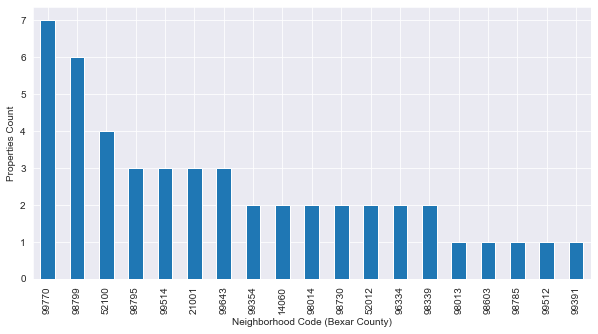

In [126]:
prop_df[prop_df.crim_prop==1]['hood_cd'].value_counts().plot(kind='bar',figsize=(10,5))
plt.ylabel('Properties Count')
plt.xlabel('Neighborhood Code (Bexar County)')
plt.show()

In [133]:
prop_df['situs_zip'] = prop_df['situs_zip'].astype('category')

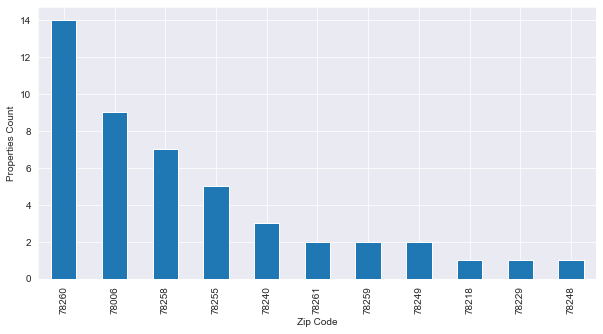

In [138]:
prop_df[prop_df.crim_prop==1]['situs_zip'].value_counts()[:11].plot(kind='bar',figsize=(10,5))
plt.ylabel('Properties Count')
plt.xlabel('Zip Code')
plt.show()

In [139]:
print(prop_df.situs_zip.nunique())

100


As plotting the locations of these properties above showed, location does seem to matter in this situation.

In [142]:
# Are these properties owned by companies or people?
print(prop_df[prop_df.crim_prop==1]['owner_legal_person'].value_counts())
print(prop_df[prop_df.crim_prop==1]['owner_likely_company'].value_counts())

1    39
0     9
Name: owner_legal_person, dtype: int64
1    41
0     7
Name: owner_likely_company, dtype: int64


In [144]:
# How does that compare to the broader population?
print(prop_df[prop_df.crim_prop!=1]['owner_legal_person'].value_counts())
print(prop_df[prop_df.crim_prop!=1]['owner_likely_company'].value_counts())

0    565782
1     55655
Name: owner_legal_person, dtype: int64
0    560770
1     60667
Name: owner_likely_company, dtype: int64


In [146]:
print(55655/565782 * 100)
print(60667/560770 * 100)

9.836827612048458
10.818517395723736


Far different than the broader population of residential real estate.

#### Visualizations on the Broader Data

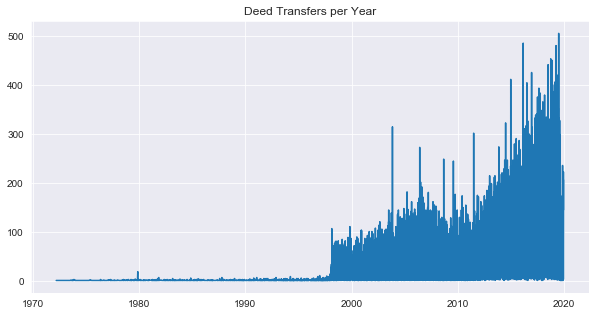

In [160]:
# What is the distribution of the deed_dt in Bexar County
plt.figure(figsize=(10,5))
plt.plot(prop_df.deed_dt.value_counts().sort_index()[200:])
plt.title("Deed Transfers per Year")
plt.show()

In [175]:
# Is the price per square foot higher for company owners or natural people?
prop_df.groupby('owner_legal_person')['price_psf'].mean()

owner_legal_person
0   105.58204
1   167.62569
Name: price_psf, dtype: float64

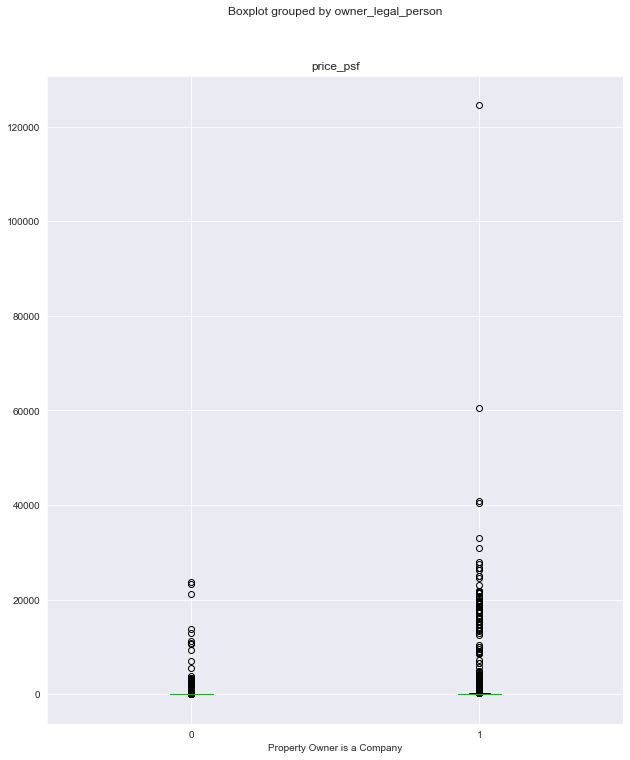

In [181]:
# Distribution of price per square foot by owner type
prop_df[['price_psf','owner_legal_person']].boxplot(by=['owner_legal_person'],figsize=(10,12))
plt.xlabel('Property Owner is a Company')
plt.show()

owner_likely_company
0   106.94543
1   148.80917
Name: price_psf, dtype: float64


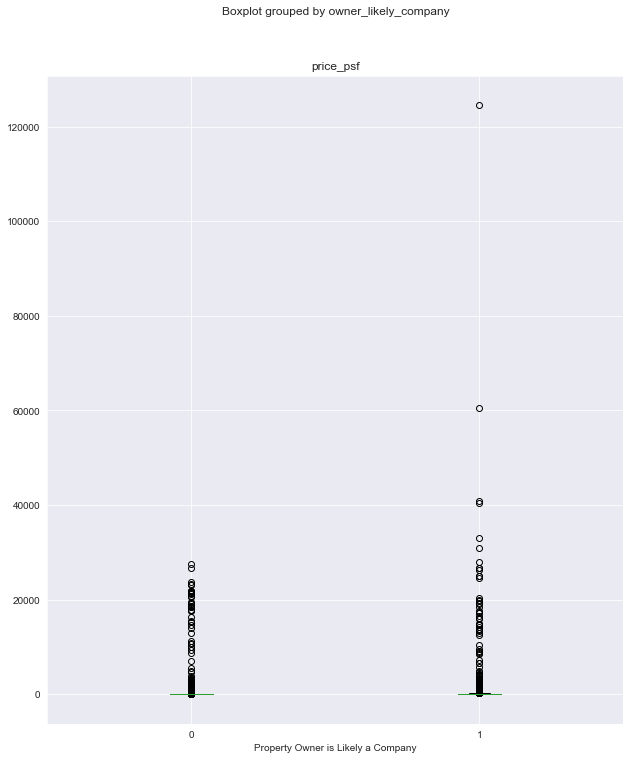

In [185]:
print(prop_df.groupby('owner_likely_company')['price_psf'].mean())
# Distribution of price per square foot by owner type
prop_df[['price_psf','owner_likely_company']].boxplot(by=['owner_likely_company'],figsize=(10,12))
plt.xlabel('Property Owner is Likely a Company')
plt.show()

owner_is_trust
0   109.56854
1   122.07123
Name: price_psf, dtype: float64


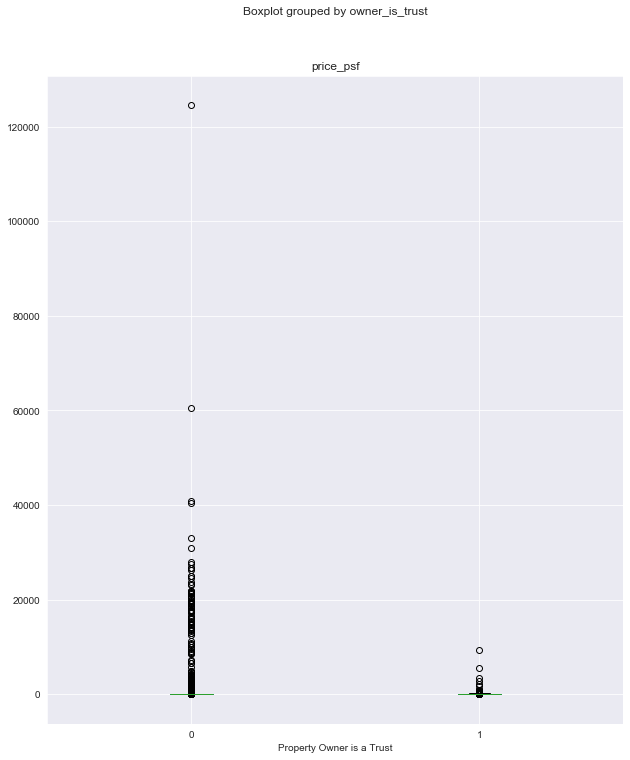

In [186]:
print(prop_df.groupby('owner_is_trust')['price_psf'].mean())
# Distribution of price per square foot by owner type
prop_df[['price_psf','owner_is_trust']].boxplot(by=['owner_is_trust'],figsize=(10,12))
plt.xlabel('Property Owner is a Trust')
plt.show()
# Far fewer outliers for trusts than for the rest of the population